In [ ]:
import numpy as np
import pandas as pd
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import time
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
sns.set_style('darkgrid')
import shutil
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import time
from keras.layers import Dense
from keras import Model
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam

In [ ]:
def preprocess (sdir, trsplit, vsplit):
    filepaths=[]
    labels=[]
    folds=os.listdir(sdir)
    for fold in folds:
        foldpath=os.path.join(sdir,fold)
        classlist=os.listdir(foldpath)
        for klass in folds:
            classpath=os.path.join(sdir,klass)
            flist=os.listdir(classpath)
            for f in flist:
                fpath=os.path.join(classpath,f)
                filepaths.append(fpath)
                labels.append(klass)
    Fseries=pd.Series(filepaths, name='filepaths')
    Lseries=pd.Series(labels, name='labels')
    df=pd.concat([Fseries, Lseries], axis=1)
    dsplit=vsplit/(1-trsplit)
    strat=df['labels']
    train_df, dummy_df=train_test_split(df, train_size=trsplit, shuffle=True, random_state=123, stratify=strat)
    strat=dummy_df['labels']
    valid_df, test_df= train_test_split(dummy_df, train_size=dsplit, shuffle=True, random_state=123, stratify=strat)
    print('train_df length: ', len(train_df), '  test_df length: ',len(test_df), '  valid_df length: ', len(valid_df))
     # check that each dataframe has the same number of classes to prevent model.fit errors
    trcount=len(train_df['labels'].unique())
    tecount=len(test_df['labels'].unique())
    vcount=len(valid_df['labels'].unique())
    if trcount < tecount :
        msg='** WARNING ** number of classes in training set is less than the number of classes in test set'
        print_in_color(msg, (255,0,0), (55,65,80))
        msg='This will throw an error in either model.evaluate or model.predict'
        print_in_color(msg, (255,0,0), (55,65,80))
    if trcount != vcount:
        msg='** WARNING ** number of classes in training set not equal to number of classes in validation set'
        print_in_color(msg, (255,0,0), (55,65,80))
        msg=' this will throw an error in model.fit'
        print_in_color(msg, (255,0,0), (55,65,80))
        print ('train df class count: ', trcount, 'test df class count: ', tecount, ' valid df class count: ', vcount)
        ans=input('Enter C to continue execution or H to halt execution')
        if ans =='H' or ans == 'h':
            print_in_color('Halting Execution', (255,0,0), (55,65,80))
            import sys
            sys.exit('program halted by user')
    print(list(train_df['labels'].value_counts()))
    return train_df, test_df, valid_df

In [ ]:
sdir=r'../pre-processing /train'
trsplit=.7
vsplit=.15
train_df, test_df, valid_df= preprocess(sdir,trsplit, vsplit)

train_df length:  20223   test_df length:  4334   valid_df length:  4333
[8001, 5306, 3661, 2649, 606]


In [ ]:
def relabel(label_in):
    if  label_in == '1' or label_in =='2':
        label='2'
    else:
        label=label_in
    return label


for df in [train_df, test_df, valid_df]:
    for i in range (len(df)):
        label=df['labels'].iloc[i]
        new_label=relabel(label)
        df['labels'].iloc[i]=new_label
print (train_df['labels'].value_counts())
print (test_df['labels'].value_counts())

2    8967
0    8001
3    2649
4     606
Name: labels, dtype: int64
2    1922
0    1715
3     568
4     129
Name: labels, dtype: int64


In [ ]:
img_size=(224,224) # size of augmented images
batch_size=20 # We will use and EfficientetB3 model, with image size of (200, 250) this size should not cause resource error
trgen=ImageDataGenerator(horizontal_flip=True,rotation_range=20 )
t_and_v_gen=ImageDataGenerator()
msg='{0:70s} for train generator'.format(' ')
print(msg, '\r', end='') # prints over on the same line
train_gen=trgen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                   class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)
msg='{0:70s} for valid generator'.format(' ')
print(msg, '\r', end='') # prints over on the same line
valid_gen=t_and_v_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                   class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size)
# for the test_gen we want to calculate the batch size and test steps such that batch_size X test_steps= number of samples in test set
# this insures that we go through all the sample in the test set exactly once.
length=len(test_df)
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]
test_steps=int(length/test_batch_size)
msg='{0:70s} for test generator'.format(' ')
print(msg, '\r', end='') # prints over on the same line
test_gen=t_and_v_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                   class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=test_batch_size)
# from the generator we can get information we will need later
classes=list(train_gen.class_indices.keys())
class_indices=list(train_gen.class_indices.values())
class_count=len(classes)
labels=test_gen.labels
print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps, ' number of classes : ', class_count)

Found 20223 validated image filenames belonging to 4 classes.
Found 4333 validated image filenames belonging to 4 classes.
Found 4334 validated image filenames belonging to 4 classes.
test batch size:  22   test steps:  197  number of classes :  4


In [ ]:
img_shape=(img_size[0], img_size[1], 3)
model_name='EfficientNetB5'
base_model=tf.keras.applications.efficientnet.EfficientNetB5(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max')
# Note you are always told NOT to make the base model trainable initially- that is WRONG you get better results leaving it trainable
base_model.trainable=True
x=base_model.output
x=BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
x=Dropout(rate=.4, seed=123)(x)
output=Dense(class_count, activation='softmax')(x)
model=Model(inputs=base_model.input, outputs=output)
lr=.001 # start with this learning rate
#model.compile(Adamax(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy'])
optimizer = Adam(lr = 0.0001)
model.compile(loss = "categorical_crossentropy",optimizer = optimizer, metrics=['accuracy'])

115263384/115263384 [==============================] - 6s 0us/step


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
hist = model.fit(train_gen, epochs= 10, validation_data= valid_gen, validation_steps=2)

Epoch 1/10
1012/1012 [==============================] - 4139s 4s/step - loss: 7.1026 - accuracy: 0.5218 - val_loss: 4.9553 - val_accuracy: 0.6500
Epoch 2/10
1012/1012 [==============================] - 602s 594ms/step - loss: 3.8782 - accuracy: 0.6773 - val_loss: 2.7450 - val_accuracy: 0.7500
Epoch 3/10
1012/1012 [==============================] - 601s 594ms/step - loss: 2.1741 - accuracy: 0.7567 - val_loss: 2.0529 - val_accuracy: 0.7750
Epoch 4/10
1012/1012 [==============================] - 602s 595ms/step - loss: 1.2595 - accuracy: 0.8071 - val_loss: 0.7826 - val_accuracy: 0.9000
Epoch 5/10
1012/1012 [==============================] - 605s 598ms/step - loss: 0.8014 - accuracy: 0.8538 - val_loss: 0.7971 - val_accuracy: 0.9250
Epoch 6/10
1012/1012 [==============================] - 603s 596ms/step - loss: 0.5307 - accuracy: 0.9013 - val_loss: 0.3842 - val_accuracy: 0.9750
Epoch 7/10
1012/1012 [==============================] - 603s 595ms/step - loss: 0.3876 - accuracy: 0.9300 - val_lo

<ipython-input-8-43960882daf6>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model.predict_generator(generator=test_gen)


<Figure size 640x480 with 0 Axes>

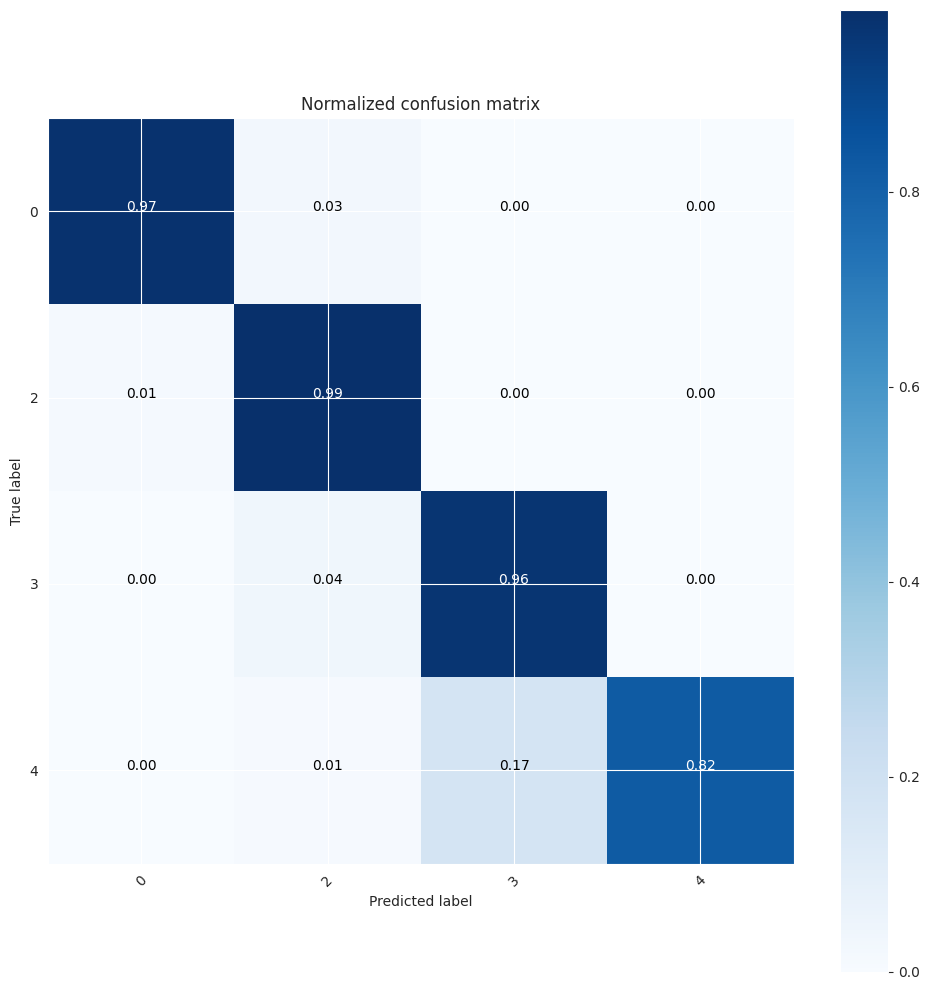

In [ ]:
predictions = model.predict_generator(generator=test_gen)
y_pred = [np.argmax(probas) for probas in predictions]
y_test = test_gen.classes
class_names = test_gen.class_indices.keys()

from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Normalized confusion matrix')
plt.show()

In [ ]:
def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout
    plt.show()

tr_plot(hist,0)